# Project 3

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Source: Natural Language Processing with Python, exercise 6.10.2.

[Explanation](https://youtu.be/sIQKkiK18Co)

## Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
import nltk
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
from sklearn.ensemble import RandomForestClassifier

## Load Names Corpus Dataset 

In [2]:
files = nltk.corpus.names.fileids()
files

['female.txt', 'male.txt']

## Merge both text files into one DataFrame

In [3]:
names_df = pd.DataFrame(columns=['name', 'gender'])

for file in files:
    gender = file.split('.')[0]  # Extract 'male' or 'female'
    temp_df = pd.DataFrame({'name': nltk.corpus.names.words(file), 'gender': gender})
    names_df = pd.concat([names_df, temp_df], ignore_index=True)

In [4]:
names_df

,name,gender
0,Abagael,female
1,Abagail,female
2,Abbe,female
3,Abbey,female
4,Abbi,female
...,...,...
7939,Zeus,male
7940,Zippy,male
7941,Zollie,male
7942,Zolly,male


## Create Training, Dev-Test and Testing Set

In [5]:
df_shuffled = shuffle(names_df, random_state=123)

train_set = df_shuffled.iloc[:len(names_df)-1000]
dev_test_set = df_shuffled.iloc[500:1000]
test_set = df_shuffled.tail(500)

print("Train Set: ", len(train_set))
print("Dev-Test Set: ", len(dev_test_set))
print("Test Set: ", len(test_set))

Train Set:  6944
Dev-Test Set:  500
Test Set:  500


## Exploratory Data Analysis

### Total Names by Gender

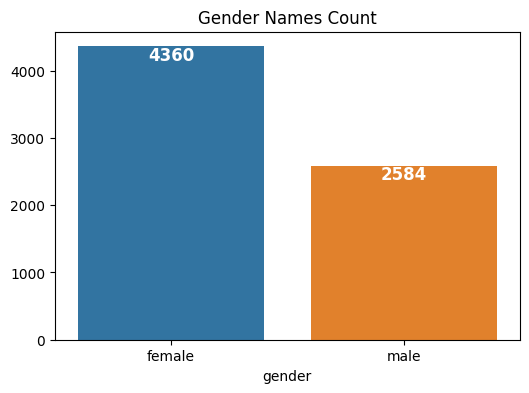

In [6]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=train_set, x='gender', hue='gender')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height() - 0.1),  # Slightly below the top
                ha='center', va='top', fontsize=12, color='white', fontweight='bold')


plt.title('Gender Names Count')
plt.ylabel('')
plt.show()

## Create Gender Features

- First Letter
- Last Letter
- First Two Letters
- Last Two Lettes
- Vowel Count
- Bigrams
- Syllables

In [7]:
def count_vowels(name):
    return sum(1 for char in name.lower() if char in 'aeiou')

def create_features(df):
    SSP = SyllableTokenizer()

    df = df.copy()
    df['name'] = df['name'].str.lower().str.strip()  # Remove spaces
    df['name'] = df['name'].str.replace(r'[^a-z]', '', regex=True)  # Keep only letters
    
    df['first_letter'] = df['name'].str[0]
    df['last_letter'] = df['name'].str[-1]
    df['first_two_letters'] = df['name'].str[:2]
    df['last_two_letters'] = df['name'].str[-2:]
    df['name_length'] = df['name'].str.len()
    df['vowel_count'] = df['name'].apply(count_vowels)
    
    df['bigram'] = df['name'].apply(lambda x: [''.join(pair) for pair in ngrams(x, 2)] if len(x) > 1 else [])
    df['bigram'] = df['bigram'].apply(lambda x: ','.join(x))  
    
    df['syllable_count'] = df['name'].apply(lambda x: len(SSP.tokenize(x)) if x else 1)

    return df

In [8]:
train_features = create_features(train_set)
test_features = create_features(dev_test_set)

In [9]:
train_features

,name,gender,first_letter,last_letter,first_two_letters,last_two_letters,name_length,vowel_count,bigram,syllable_count
803,carrie,female,c,e,ca,ie,6,3,"ca,ar,rr,ri,ie",2
2939,leisha,female,l,a,le,ha,6,3,"le,ei,is,sh,ha",2
4061,rayna,female,r,a,ra,na,5,2,"ra,ay,yn,na",2
3241,malinde,female,m,e,ma,de,7,3,"ma,al,li,in,nd,de",3
4729,toni,female,t,i,to,ni,4,2,"to,on,ni",2
...,...,...,...,...,...,...,...,...,...,...
5055,albrecht,male,a,t,al,ht,8,2,"al,lb,br,re,ec,ch,ht",2
6244,inglebert,male,i,t,in,rt,9,3,"in,ng,gl,le,eb,be,er,rt",3
1977,gipsy,female,g,y,gi,sy,5,1,"gi,ip,ps,sy",2
6807,neale,male,n,e,ne,le,5,3,"ne,ea,al,le",2


### Relative Frequency of First Letter by Gender

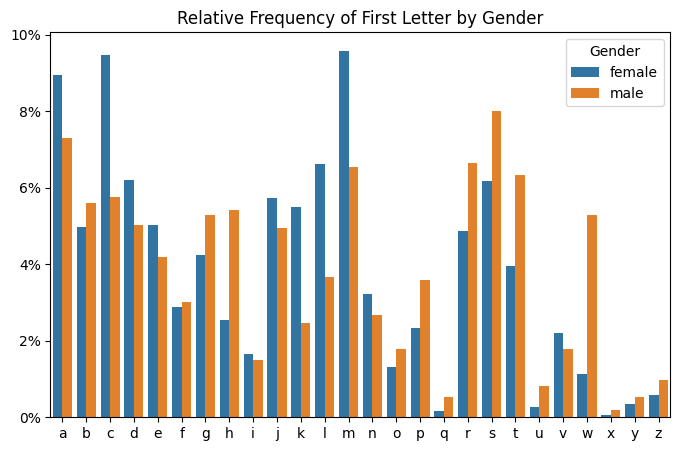

In [10]:
gender_counts = train_features.groupby(['gender', 'first_letter']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='first_letter', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of First Letter by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

### Relative Frequency of Last Letter by Gender

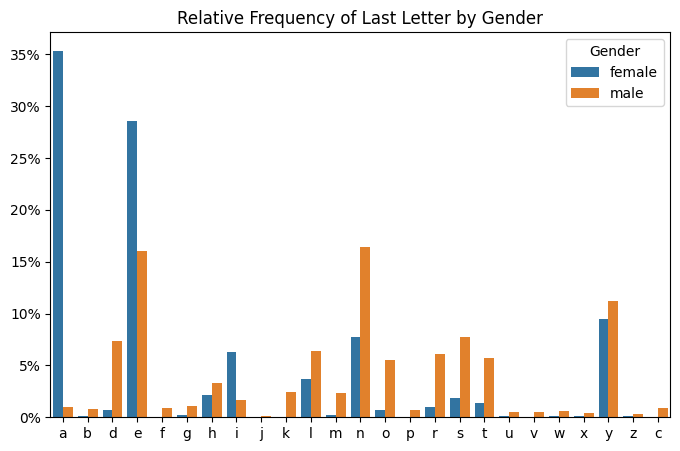

In [11]:
gender_counts = train_features.groupby(['gender', 'last_letter']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='last_letter', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of Last Letter by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

### Relative Frequency of Name Length by Gender

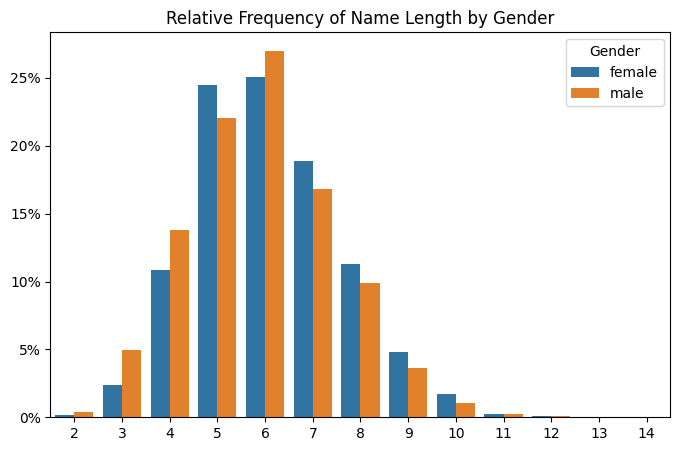

In [12]:
gender_counts = train_features.groupby(['gender', 'name_length']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='name_length', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of Name Length by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

### Relative Frequency of Vowel Count by Gender

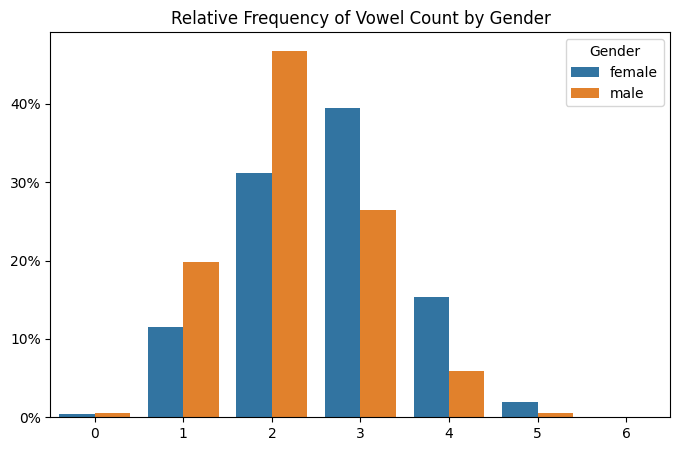

In [13]:
gender_counts = train_features.groupby(['gender', 'vowel_count']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='vowel_count', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of Vowel Count by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

### Relative Frequency of Syllable Count by Gender

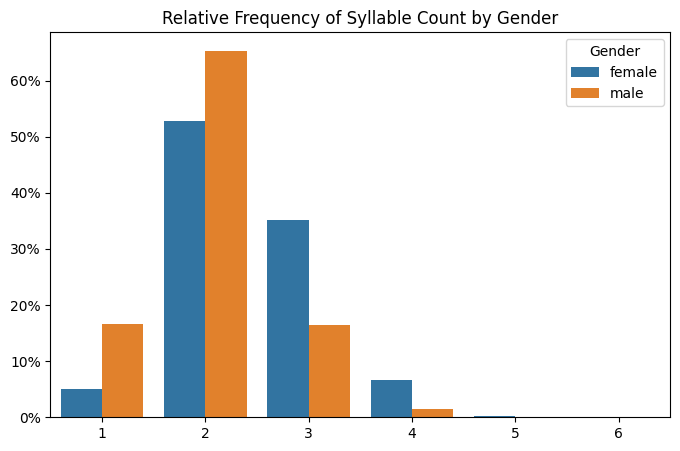

In [14]:
gender_counts = train_features.groupby(['gender', 'syllable_count']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='syllable_count', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of Syllable Count by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

## Model Development

### Feature Extraction

In [15]:
train_features = create_features(train_set)
test_features = create_features(dev_test_set)

In [16]:
vectorizer = DictVectorizer(sparse=False)
X_train = vectorizer.fit_transform(train_features.drop(columns=['name', 'gender']).to_dict(orient='records'))
y_train = train_features['gender']

X_test = vectorizer.transform(test_features.drop(columns=['name', 'gender']).to_dict(orient='records'))
y_test = test_features['gender']

### Decision Tree

In [17]:
dt_classifier = DecisionTreeClassifier(max_depth=4)

dt_classifier.fit(X_train, y_train)
dt_preds = dt_classifier.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_preds)
print(f'Decision Tree Accuracy: {dt_accuracy:.2f}')

Decision Tree Accuracy: 0.75


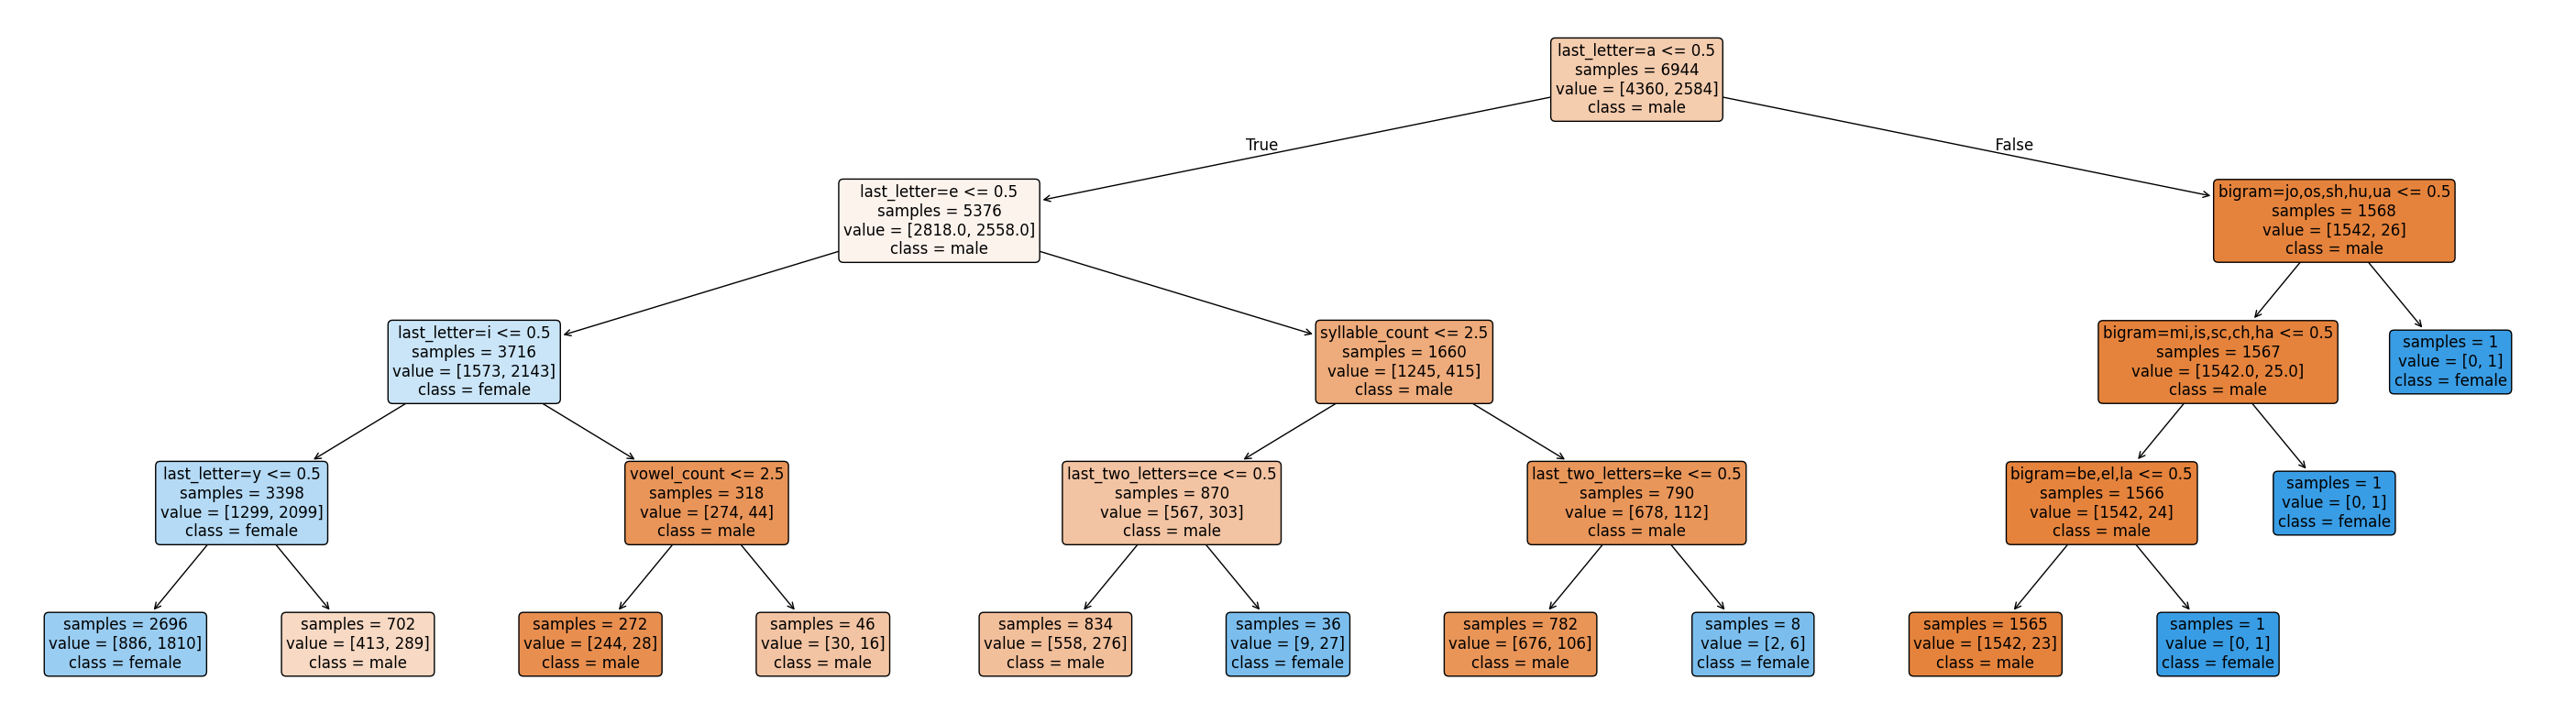

In [18]:
plt.figure(figsize=(36, 10))  
plot_tree(
    dt_classifier, 
    filled=True, 
    feature_names=vectorizer.get_feature_names_out(),  
    class_names=['male', 'female'],  
    rounded=True, 
    fontsize=12, 
    impurity=False,
    label='all'
)
plt.show()

### Naive Bayes Classifiers

In [19]:
nb_train_data = [(dict(row), label) for row, label in zip(train_features.drop(columns=['name', 'gender']).to_dict(orient='records'), y_train)]
nb_test_data = [(dict(row), label) for row, label in zip(test_features.drop(columns=['name', 'gender']).to_dict(orient='records'), y_test)]

nb_classifier = NaiveBayesClassifier.train(nb_train_data)
nb_accuracy = accuracy(nb_classifier, nb_test_data)
print(f'Naive Bayes Accuracy: {nb_accuracy:.2f}')

Naive Bayes Accuracy: 0.85


In [20]:
nb_classifier.show_most_informative_features(5)

Most Informative Features
        last_two_letters = 'na'           female : male   =     91.6 : 1.0
        last_two_letters = 'ia'           female : male   =     89.7 : 1.0
             last_letter = 'k'              male : female =     72.4 : 1.0
        last_two_letters = 'la'           female : male   =     70.4 : 1.0
        last_two_letters = 'ld'             male : female =     35.8 : 1.0


### Random Forest

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=100)

rf_classifier.fit(X_train, y_train)
rf_preds = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

print(f'Random Forest Accuracy: {rf_accuracy:.2f}')

Random Forest Accuracy: 0.95


## Results

In [22]:
test_features = create_features(test_set)
X_test = vectorizer.transform(test_features.drop(columns=['name', 'gender']).to_dict(orient='records'))
y_test = test_features['gender']

In [23]:
from sklearn.metrics import classification_report

dt_test_preds = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_test_preds)
print(f'Decision Tree Test Accuracy: {dt_accuracy:.2f}')
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_test_preds))

Decision Tree Test Accuracy: 0.75
Decision Tree Classification Report:
              precision    recall  f1-score   support

      female       0.82      0.78      0.80       324
        male       0.64      0.69      0.66       176

    accuracy                           0.75       500
   macro avg       0.73      0.74      0.73       500
weighted avg       0.76      0.75      0.75       500



In [24]:
nb_test_preds = [nb_classifier.classify(dict(row)) for row in test_features.drop(columns=['name', 'gender']).to_dict(orient='records')]
nb_accuracy = accuracy_score(y_test, nb_test_preds)
print(f'Naive Bayes Test Accuracy: {nb_accuracy:.2f}')
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_test_preds))

Naive Bayes Test Accuracy: 0.81
Naive Bayes Classification Report:
              precision    recall  f1-score   support

      female       0.89      0.81      0.85       324
        male       0.70      0.81      0.75       176

    accuracy                           0.81       500
   macro avg       0.79      0.81      0.80       500
weighted avg       0.82      0.81      0.81       500



In [25]:
rf_test_preds = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_test_preds)
print(f'Random Forest Test Accuracy: {rf_accuracy:.2f}')
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_test_preds))

Random Forest Test Accuracy: 0.81
Random Forest Classification Report:
              precision    recall  f1-score   support

      female       0.84      0.88      0.86       324
        male       0.76      0.69      0.72       176

    accuracy                           0.81       500
   macro avg       0.80      0.79      0.79       500
weighted avg       0.81      0.81      0.81       500



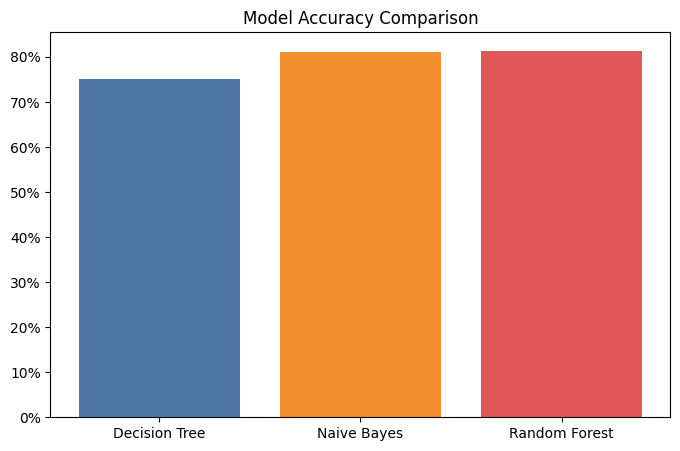

In [26]:
models = ['Decision Tree', 'Naive Bayes', 'Random Forest']
accuracies = [dt_accuracy, nb_accuracy, rf_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['#4E79A7', '#F28E2B', '#E15759'])
plt.xlabel('')
plt.ylabel('')
plt.title('Model Accuracy Comparison')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.show()